In [5]:
# general tools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import re
import datetime as dt
import json
import requests
import scipy as sp
import numpy as np
import tempfile
import random
import time
import math
import statistics
import os
from typing import Tuple, Dict, List
import sys
import warnings
warnings.filterwarnings('ignore')

# preprocessing & utils
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# ml models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier

# others
from wordcloud import WordCloud
from matplotlib.ticker import FormatStrFormatter

<center>
    <h3>Constant</h3>
</center>

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

<center>
    <h3>Utility Function</h3>
</center>

In [69]:
# processsing
def pipe_cleaningText(text: str) -> str:
    txt = text.lower()
    return txt

def pipe_removeStopWords(text: str, tokenized: bool = False) -> str:
    if tokenized:
        return " ".join([w for w in text.split(" ") if w not in stop_words])
    return " ".join([w for w in word_tokenize(text) if w not in stop_words])

def pipe_lemmatization(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    for w in collections:
        txt += lemmatizer.lemmatize(w) + ' '
    return txt.strip()

def pipe_addPos(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    for w in pos_tag(collections):
        txt += '__'.join(w) + ' '
    return txt.strip()

def pipe_normalized(text: str, bin: int, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    n = len(collections)
    for i, w in enumerate(collections):
        normVal = math.floor((i / (n - 1)) * (bin - 1)) + 1 if n != 1 else 1
        txt += w + '__' + str(normVal) + ' '
    return txt.strip()

def pipe_subjectCleaning(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = sent_tokenize(text) if not tokenized else text.split(" ")
    for s in collections:
        for w in pos_tag(word_tokenize(s)):
            if w[1] != 'NNP':
                continue
            txt += w[0] + ' '
    return txt.strip()

# feature extraction
def feature_tfidfUni(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, TfidfVectorizer]:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUni(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, CountVectorizer]:
    bow_vectorizer = CountVectorizer(ngram_range=(1,1), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

def feature_tfidfUniBi(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, TfidfVectorizer]:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUniBi(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, CountVectorizer]:
    bow_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

# sampling
def balancing_upsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    highest_n = max(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == highest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == highest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, highest_n - group_res.loc[i], replace=True)
        thedata = pd.concat([thedata, tdata, tdata.loc[sample_ind]])
    return thedata

def balancing_downsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    lowest_n = min(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == lowest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == lowest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, lowest_n, replace=False)
        thedata = pd.concat([thedata, tdata.loc[sample_ind]])
    return thedata

# testing
def accuracyTrainTest(model, trainX: np.array, trainY: np.array, valX: np.array, valY: np.array, testX: np.array, testY: np.array) -> Tuple[float, float, float]:
    mod = model.fit(trainX, trainY)
    yfit = mod.predict(trainX)
    ypredVal = mod.predict(valX)
    ypredTest = mod.predict(testX)
    
    # train result, validation result, test result
    return accuracy_score(trainY, yfit), accuracy_score(valY, ypredVal), accuracy_score(testY, ypredTest)
    
def loop_testing(model, n_test: int, xArr: sp.sparse.csr_matrix, yArr: np.array, testXArr: sp.sparse.csr_matrix, testYArr: np.array) -> Dict[str, List[float]]:
    thedict = {}

    i = 0
    n = xArr.shape[0]
    n_sample = math.ceil(n / n_test)
    x_sam, y_sam = np.array([]), np.array([])
    while i < n_test:
        percent_sample = n_sample/xArr.shape[0]
        if percent_sample >= 1:
            xmain, ymain = xArr, yArr
        else:
            xmain, xArr, ymain, yArr = train_test_split(xArr, yArr, train_size=percent_sample, stratify=yArr, random_state=123)
        
        x_sam = sp.sparse.vstack((x_sam, xmain)) if x_sam.shape[0] != 0 else xmain
        y_sam = np.hstack((y_sam, ymain)) if y_sam.shape[0] != 0 else ymain
        xtrain, xtest, ytrain, ytest = train_test_split(x_sam, y_sam, train_size=0.9, stratify=y_sam, random_state=123)

        resTrain, resVal, resTest = accuracyTrainTest(model, xtrain, ytrain, xtest, ytest, testXArr, testYArr)
        thedict[x_sam.shape[0]] = [resTrain, resVal, resTest]

        i += 1
    return thedict

# visualization
def show_result(ypred: np.array, ytarget: np.array) -> None:
    label = ['Positive', 'Neutral', 'Negative']
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Neu', 'False Neg',
                   'False Pos', 'True Neu', 'False Neg',
                   'False Pos', 'False Neu', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(3, 3)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

def visualized_loopTesting(result_loopTesting: Dict[str, List[float]]) -> None:
    train_res, val_res, test_res = dict(), dict(), dict()
    for res in result_loopTesting:
        train_res[res] = result[res][0]
        val_res[res] = result[res][1]
        test_res[res] = result[res][2]

    fig, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.lineplot(y=train_res.values(), x=train_res.keys() , ax=axe, label='train-result')
    sns.lineplot(y=val_res.values(), x=val_res.keys(), ax=axe, label='val-result')
    sns.lineplot(y=test_res.values(), x=test_res.keys(), ax=axe, label='test-result')
    axe.set_title("Highest Score: {}".format(max(test_res.values())))
    axe.set_xlabel("Dataset Size")
    axe.set_ylabel("Accuracy")
    axe.set_ylim([0.65, 1.0])
    axe.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.show();

# others
def correlation(x: list, y: list) -> float:
    x = np.array(x)
    y = np.array(y)
    bar_x = x.mean()
    bar_y = y.mean()
    sum_xixbar_yiybar = sum((x - bar_x) * (y - bar_y))
    sum_xixbar2 = sum((x - bar_x) ** 2)
    sum_yiybar2 = sum((y - bar_y) ** 2)

    numer = sum_xixbar_yiybar
    denom = (sum_xixbar2 * sum_yiybar2) ** (1 / 2)

    r = numer / denom if denom != 0 else 0

    return r

def gradient(x: list, y: list) -> float:
    p1 = [x[0], y[0]]
    p2 = [x[2], y[2]]

    numer = p1[1] - p2[1]
    denom = p1[0] - p2[0]

    return numer / denom
    

<center>
    <h3>Process</h3>
</center>

Goals
- Try training using binary output (1 & 5) & measure performance on all output (1 to 5)

In [10]:
df = pd.read_csv('../data/Amazon_Electronics.csv')

In [11]:
df.describe()

,overall,unixReviewTime
count,2.094154e+07,2.094154e+07
mean,4.073490e+00,1.425820e+09
std,1.385862e+00,7.772530e+07
min,1.000000e+00,8.811936e+08
25%,4.000000e+00,1.393891e+09
50%,5.000000e+00,1.440461e+09
75%,5.000000e+00,1.478563e+09
max,5.000000e+00,1.538698e+09


In [12]:
df.isnull().sum()

overall                  0
verified                 0
reviewTime               0
reviewerID               0
asin                     0
style             10476370
reviewerName          2668
reviewText            9670
summary               4896
unixReviewTime           0
vote              18254610
image             20594419
dtype: int64

<AxesSubplot:xlabel='overall'>

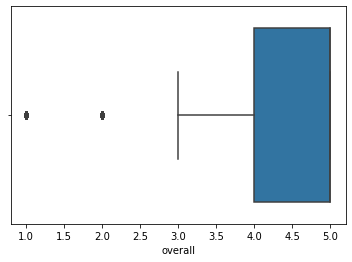

In [13]:
sns.boxplot(df['overall'])

<AxesSubplot:xlabel='overall', ylabel='Count'>

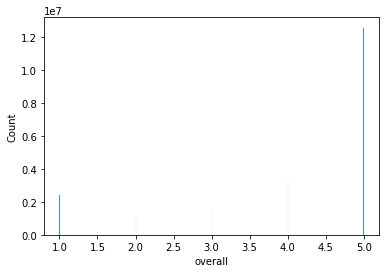

In [14]:
sns.histplot(df['overall'])

In [28]:
dfdata = df[['reviewText', 'overall']]
dfdata.head()

,reviewText,overall
0,This was the first time I read Garcia-Aguilera...,5
1,"As with all of Ms. Garcia-Aguilera's books, I ...",5
2,I've not read any of Ms Aguilera's works befor...,5
3,This romance novel is right up there with the ...,4
4,Carolina Garcia Aguilera has done it again. S...,5


In [29]:
dfdata.isnull().sum()

reviewText    9670
overall          0
dtype: int64

In [30]:
dfdata = dfdata[(~dfdata.isnull().any(axis=1)) & (dfdata.reviewText.apply(lambda x: str(x).strip() != ""))]

In [31]:
dfdata.isnull().sum()

reviewText    0
overall       0
dtype: int64

In [35]:
target_n = 500 * 1000
dfdataMain, _ = train_test_split(dfdata, train_size=target_n / dfdata.shape[0], stratify=dfdata['overall'], random_state=123)

In [36]:
dfdataMain.shape

(500000, 2)

In [38]:
# for training & testing
target_n = 480 * 1000
dfdataTrain, dfdataTest = train_test_split(dfdataMain, train_size=target_n / dfdataMain.shape[0], stratify=dfdataMain['overall'], random_state=123)

In [39]:
# for validation
target_n = 48 * 1000
dfdataValid, dfdataTrainSub = train_test_split(dfdataTrain, train_size=target_n / dfdataTrain.shape[0], stratify=dfdataTrain['overall'], random_state=123)

In [40]:
# for validation training & testing
target_n = 45 * 1000
dfdataValidTrain, dfdataValidTest = train_test_split(dfdataValid, train_size=target_n / dfdataValid.shape[0], stratify=dfdataValid['overall'], random_state=123)

In [42]:
# update the dataset for training, to only use 1 & 5 as output
dfdataTrain = dfdataTrain[dfdataTrain['overall'].apply(lambda x: x in (1, 5))]
dfdataTrainSub = dfdataTrainSub[dfdataTrainSub['overall'].apply(lambda x: x in (1, 5))]
dfdataValidTrain = dfdataValidTrain[dfdataValidTrain['overall'].apply(lambda x: x in (1, 5))]

In [48]:
print((dfdataTrain.shape[0]/480000) * 100)
print((dfdataTrainSub.shape[0]/432000) * 100)
print((dfdataValidTrain.shape[0]/45000) * 100)

71.52395833333334
71.52407407407408
71.52444444444444


<AxesSubplot:xlabel='overall', ylabel='Count'>

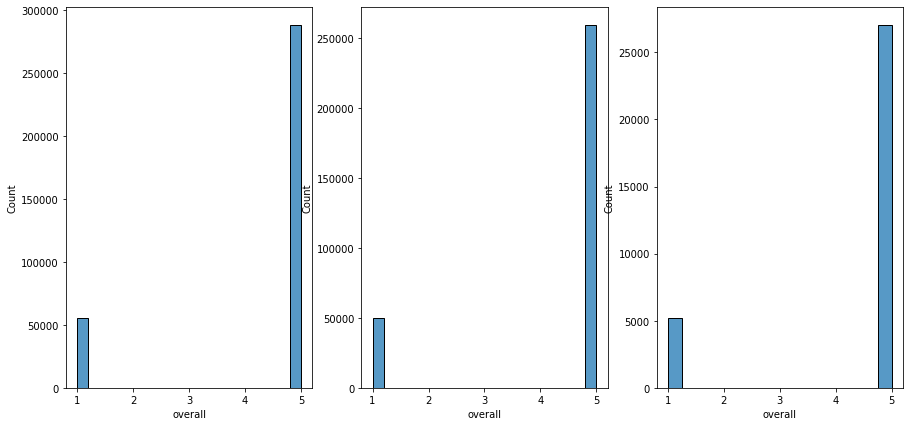

In [61]:
fig, axes = plt.subplots(figsize=(15,7), nrows=1, ncols=3)
sns.histplot(dfdataTrain['overall'], ax=axes[0])
sns.histplot(dfdataTrainSub['overall'], ax=axes[1])
sns.histplot(dfdataValidTrain['overall'], ax=axes[2])

In [62]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

238187138

In [63]:
# validation for processing

In [64]:
# upsampling minority group for validation training
if statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values) >= 10 * 1000:
    dfdataValidTrain = balancing_upsampling(dfdataValidTrain)

<AxesSubplot:xlabel='overall', ylabel='Count'>

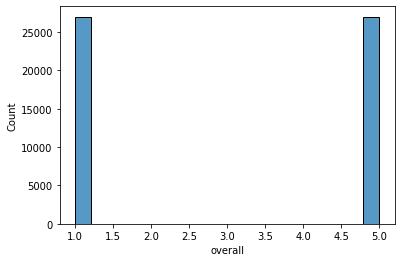

In [65]:
# sample resulf of sampling
sns.histplot(dfdataValidTrain['overall'])

In [66]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

0

In [67]:
mlp_model = MLPClassifier(verbose=True, early_stopping=True, tol=1e-5)

Iteration 1, loss = 0.58649740
Validation score: 0.874743
Iteration 2, loss = 0.29907426
Validation score: 0.903491
Iteration 3, loss = 0.17128245
Validation score: 0.901437
Iteration 4, loss = 0.10971423
Validation score: 0.899384
Iteration 5, loss = 0.07596988
Validation score: 0.895277
Iteration 6, loss = 0.05564607
Validation score: 0.901437
Iteration 7, loss = 0.04234824
Validation score: 0.901437
Iteration 8, loss = 0.03325580
Validation score: 0.899384
Iteration 9, loss = 0.02679484
Validation score: 0.901437
Iteration 10, loss = 0.02206464
Validation score: 0.901437
Iteration 11, loss = 0.01839779
Validation score: 0.905544
Iteration 12, loss = 0.01559822
Validation score: 0.899384
Iteration 13, loss = 0.01342089
Validation score: 0.901437
Iteration 14, loss = 0.01163802
Validation score: 0.901437
Iteration 15, loss = 0.01021337
Validation score: 0.901437
Iteration 16, loss = 0.00903463
Validation score: 0.901437
Iteration 17, loss = 0.00803718
Validation score: 0.901437
Iterat

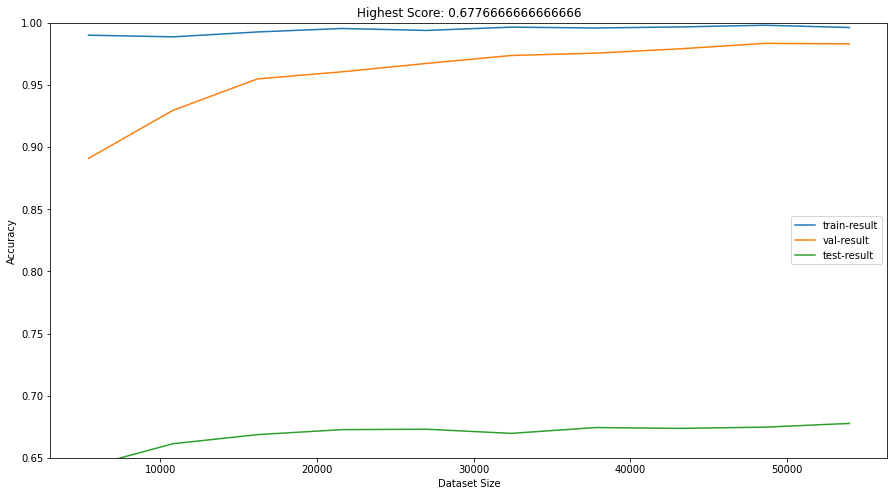

In [70]:
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(mlp_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

18203098    i__NN__1 bought__VBD__1 the__DT__1 square__NN_...
4261385     this__DT__1 unit__NN__1 has__VBZ__1 both__DT__...
19291915    tedious__JJ__1 installation__NN__1 ,__,__1 dul...
Name: reviewText, dtype: object

In [83]:
testXArr[:4][0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [93]:
mlp_model.predict_proba(testXArr[:4])[:,1]

array([0.99997833, 0.98089782, 0.52083078, 0.9996048 ])

In [92]:
(mlp_model.predict_proba(testXArr[:4])[:,1]//0.2) + 1

array([5., 5., 3., 5.])

In [84]:
mlp_model.predict(testXArr[:4])

array([5, 5, 5, 5], dtype=int64)

In [96]:
testXArr.shape

(3000, 88084)

In [97]:
testYArr.shape

(3000,)

In [102]:
set(testYArr)

{1, 2, 3, 4, 5}

In [ ]:
set(mlp_model.predict(testXArr))

In [103]:
yHat = (mlp_model.predict_proba(testXArr)[:,1]//0.2) + 1
show_result(yHat, testYArr)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''